In [1]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('../../data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('../../data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('../../data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('../../data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train['cvssV3_attackVector'].value_counts(dropna=False) / y_train.shape[0])
print(y_test['cvssV3_attackVector'].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
NETWORK             0.739842
LOCAL               0.222314
ADJACENT_NETWORK    0.024648
PHYSICAL            0.013195
Name: cvssV3_attackVector, dtype: float64
NETWORK             0.744720
LOCAL               0.217219
ADJACENT_NETWORK    0.025432
PHYSICAL            0.012629
Name: cvssV3_attackVector, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector         

**Training Hugging Face Bert-Small model to classify CVE vulnerability descriptions according to their "attack vector"**

**Attack vector**: This metric reflects the context by which vulnerability exploitation is possible. This metric value (and consequently the Base Score) will be larger the more remote (logically, and physically) an attacker can be in order to exploit the vulnerable component. The assumption is that the number of potential attackers for a vulnerability that could be exploited from across a network is larger than the number of potential attackers that could exploit a vulnerability requiring physical access to a device, and therefore warrants a greater Base Score.

In [2]:
label_column_name = "cvssV3_attackVector"
train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

NUM_CLASSES = len(le.classes_)
print(NUM_CLASSES)

encoded_train_labels = le.transform(train_labels)
encoded_test_labels = le.transform(test_labels)

print(train_labels[:10], encoded_train_labels[:10])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

['ADJACENT_NETWORK' 'LOCAL' 'NETWORK' 'PHYSICAL']
4
0    PHYSICAL
1     NETWORK
2     NETWORK
3     NETWORK
4     NETWORK
5     NETWORK
6     NETWORK
7     NETWORK
8     NETWORK
9       LOCAL
Name: cvssV3_attackVector, dtype: object [3 2 2 2 2 2 2 2 2 1]
22963 22963 22963 22963


In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-small')

In [4]:
train_encodings = tokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)

In [5]:
import torch

class CVEDataset(torch.utils.data.Dataset):
    def __init__(self, X, encodings, labels, encoded_labels):
        self.cve_id = X.loc[:,"CVE_ID"].tolist()
        self.texts = X.loc[:,"Description"].tolist()
        self.encodings = encodings
        self.labels = labels.tolist()
        self.encoded_labels = encoded_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text_labels'] = self.labels[idx]
        item['encoded_labels'] = torch.tensor(self.encoded_labels[idx])
        item['CVE_ID'] = self.cve_id[idx]
        item['vulnerability_description'] = self.texts[idx]
        
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

In [7]:
train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=NUM_CLASSES)
model

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [9]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

classifier.weight tensor([[-0.0122,  0.0212,  0.0270,  ...,  0.0061,  0.0083, -0.0170],
        [ 0.0177,  0.0199, -0.0010,  ..., -0.0036, -0.0119,  0.0332],
        [ 0.0184, -0.0072,  0.0185,  ..., -0.0150, -0.0557, -0.0077],
        [ 0.0020,  0.0268, -0.0065,  ...,  0.0122, -0.0244, -0.0014]])
classifier.bias tensor([0., 0., 0., 0.])


In [10]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.7398539948330022, Training Accuracy = 0.7246439925096895
Epoch: 1, Training Loss: 0.6663061544822805, Training Accuracy = 0.740190741627836
Epoch: 2, Training Loss: 0.648137279593643, Training Accuracy = 0.7418020293515656


In [11]:
for param in model.base_model.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
         -1.9798e-02,  4.2636e-03],
        [ 2.8236e-02, -1.1161e-02,  1.2986e-02,  ..., -1.31

In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.37479354093669004, Training Accuracy = 0.8630840917998519
Epoch: 1, Training Loss: 0.24878648948634133, Training Accuracy = 0.9113791751948788
Epoch: 2, Training Loss: 0.18276178184332958, Training Accuracy = 0.9333275268910857


In [13]:
#model.save_pretrained('./bert-small-vulnerability_attack_vector-classification')

In [14]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.3010878892403646, Test Accuracy = 0.9114662718285939


**Save the predictions obtained on the test set for further analysis**

In [15]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_attack_vector-classification')
model.eval()

test_loader = DataLoader(test_dataset, batch_size=16)


num_correct = 0 
num_examples = 0
test_loss = 0
predicted_labels_list = []
predicted_labels_score_list = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    predicted_labels = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1]
    predicted_labels_list.extend(predicted_labels.tolist())
    predicted_labels_score = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0]
    predicted_labels_score_list.extend(predicted_labels_score.tolist())
    correct = torch.eq(predicted_labels, labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))
print('predicted labels:', predicted_labels_list, 'scores:', predicted_labels_score_list)

Test Loss: 0.3010878892403646, Test Accuracy = 0.9114662718285939
predicted labels: [2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predicted_labels_list)

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.9114662718285939
precision:  0.9090257255140843
recall:  0.9114662718285939
f1 score:  0.9089126293580084
confusion matrix: 
[[  349    20   207     8]
 [   24  3887  1056    21]
 [   65   495 16514    27]
 [    6    41    63   180]]


In [17]:
class_label = list(le.classes_)
class_label
predicted_labels_char = [class_label[i] for i in predicted_labels_list]

print(len(predicted_labels_char))
print(len(predicted_labels_list))

22963
22963


(array([5.0000e+00, 1.9000e+01, 1.0400e+02, 4.5600e+02, 4.0700e+02,
        4.4900e+02, 5.0400e+02, 6.9400e+02, 1.0060e+03, 1.9319e+04]),
 array([0.28851882, 0.35961364, 0.43070847, 0.50180329, 0.57289812,
        0.64399295, 0.71508777, 0.7861826 , 0.85727742, 0.92837225,
        0.99946707]),
 <BarContainer object of 10 artists>)

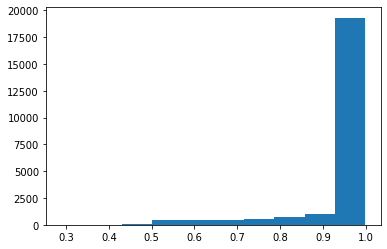

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predicted_labels_score_list, bins=10)

In [19]:
from scipy import stats

print("percentile of 0.9: ", stats.percentileofscore(predicted_labels_score_list, 0.95))

percentile of 0.9:  18.155293297914035


In [20]:
file_name = 'attack_vector'

import pickle

with open(file_name + "_predicted_class_int.txt", "wb") as f1:
    pickle.dump(predicted_labels_list, f1)
    
with open(file_name + "_predicted_labels_char.txt", "wb") as f2:
    pickle.dump(predicted_labels_char, f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "wb") as f3:
    pickle.dump(predicted_labels_score_list, f3)

In [21]:
with open(file_name + "_predicted_class_int.txt", "rb") as f1:
    pred_class = pickle.load(f1)
    
with open(file_name + "_predicted_labels_char.txt", "rb") as f2:
    pred_label = pickle.load(f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "rb") as f3:
    pred_confidence_score = pickle.load(f3)
    
print(len(pred_class), len(pred_label), len(pred_confidence_score))
print(pred_class, pred_label, pred_confidence_score)

22963 22963 22963
[2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 

**Explaining classification results using gradient-based saliency**

In [8]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_attack_vector-classification/')
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [73]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
test_batch['input_ids']
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

tensor(0.5638, grad_fn=<NllLossBackward>)
tensor([[-2.3332,  2.4268,  1.0627, -3.4178],
        [-0.2674, -0.8203,  3.0389, -3.3004],
        [-0.4339,  1.1973, -1.7495,  4.6800],
        [-2.4228,  2.0890,  1.4841, -3.5883],
        [-3.6294, -2.0622,  5.3480, -4.3589],
        [-3.8163,  3.7595,  0.9385, -3.3446],
        [ 4.5760, -1.3158, -0.6418, -1.9270],
        [-2.6679, -1.7477,  4.9378, -4.4540],
        [-3.8970,  1.5558,  2.6122, -4.0433],
        [-2.9071, -1.3523,  5.1129, -5.2207],
        [ 0.0462, -2.5164,  4.1064, -4.3184],
        [-2.8826, -2.6335,  5.2886, -4.0251],
        [-2.1723, -2.5876,  5.0456, -4.3092],
        [-2.5201, -2.3517,  5.1926, -4.3315],
        [-2.2085, -2.8976,  5.0242, -4.0918],
        [-4.3514, -0.9999,  5.2349, -4.7026]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.7892, 0.9438, 0.9631, 0.6408, 0.9992, 0.9426, 0.9904, 0.9982, 0.7405,
        0.9981, 0.9816, 0.9993, 0.9987, 0.9990, 0.9988, 0.9979],
       grad_fn=<MaxB

In [74]:
selected_idx = 6
input_ids[selected_idx].tolist()

[101,
 13990,
 2491,
 4834,
 2968,
 2005,
 2070,
 13420,
 1006,
 1054,
 1007,
 9949,
 2630,
 19392,
 1006,
 1054,
 1007,
 3688,
 2089,
 3499,
 2019,
 4895,
 18098,
 12848,
 9463,
 5999,
 5310,
 2000,
 9280,
 9585,
 14920,
 1997,
 2326,
 3081,
 5516,
 3229,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [75]:
#transform each input token into an one-hot encoded representation.

from torch.autograd import Variable

input_embedding = model.get_input_embeddings()
vocab_size = input_embedding.weight.shape[0]

input_ids_one_hot = torch.nn.functional.one_hot(input_ids[selected_idx], num_classes=vocab_size)
input_ids_one_hot = input_ids_one_hot.type(torch.float)
input_ids_one_hot = Variable(input_ids_one_hot, requires_grad=True) #to allow the computation of the gradients with respect to the input 
print(input_ids_one_hot.grad)

None


In [76]:
#Calculate the input embeddings manually and pass them to the model through the inputs_embeds argument
inputs_embeds = torch.matmul(input_ids_one_hot, input_embedding.weight)
embedding_dim = input_embedding.weight.shape[1]
inputs_embeds = torch.mul(inputs_embeds, torch.cat([attention_mask[selected_idx].unsqueeze(1)]*embedding_dim, dim=1))


outputs = model(inputs_embeds=inputs_embeds.unsqueeze(0), attention_mask=attention_mask[selected_idx].unsqueeze(0), labels=labels[selected_idx].unsqueeze(0))

print("loss:", outputs.loss)
print("logits:", outputs.logits)

predicted_label = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1].item()
print("predicted label (after softmax):", predicted_label)
print("score for predicted label (after softmax):", torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0].item())
print("sample true label:", labels[selected_idx])

outputs.logits[0][predicted_label].backward() #compute the gradient of the logit (predicted, the one with the highest score)
print(input_ids_one_hot.grad)                  #with respect to the input

loss: tensor(0.0096, grad_fn=<NllLossBackward>)
logits: tensor([[ 4.5760, -1.3158, -0.6418, -1.9270]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 0
score for predicted label (after softmax): 0.990412175655365
sample true label: tensor(0)
tensor([[-0.0064, -0.0204,  0.0067,  ..., -0.0090, -0.0027,  0.0032],
        [ 0.0189,  0.0110,  0.0224,  ...,  0.0244,  0.0285,  0.0264],
        [-0.0227, -0.0160, -0.0036,  ..., -0.0144, -0.0129,  0.0023],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [77]:
connectivity_tensor = torch.linalg.norm(input_ids_one_hot.grad, dim=1)
connectivity_tensor = connectivity_tensor/torch.max(connectivity_tensor)
connectivity_tensor

tensor([0.0838, 0.0772, 0.0637, 0.0685, 0.1357, 0.0340, 0.0650, 0.2602, 0.0848,
        0.0294, 0.0233, 0.1213, 0.0917, 0.2073, 0.0578, 0.0423, 0.0466, 0.0488,
        0.0479, 0.0397, 0.0622, 0.0777, 0.0501, 0.0292, 0.0287, 0.0447, 0.0459,
        0.0492, 0.0809, 0.0806, 0.0679, 0.0431, 0.0945, 0.1666, 1.0000, 0.1370,
        0.0391, 0.0886, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [78]:
indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
input_tokens = tokenizer.convert_ids_to_tokens(list(input_ids[selected_idx]))
top_3_indices_sorted = indices_sorted_by_connectivity[-3:].flip(dims=(0,))

print(input_tokens)
print("Most influential words by order:")
for position, score in zip(top_3_indices_sorted,
                                 connectivity_tensor[top_3_indices_sorted]):
    print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())

['[CLS]', 'insufficient', 'control', 'flow', 'management', 'for', 'some', 'intel', '(', 'r', ')', 'wireless', 'blue', '##tooth', '(', 'r', ')', 'products', 'may', 'allow', 'an', 'un', '##pr', '##iv', '##ile', '##ged', 'user', 'to', 'potentially', 'enable', 'denial', 'of', 'service', 'via', 'adjacent', 'access', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [79]:
import re

def print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=3):
    #input_text_str: python string coreesponding to the raw textual input
    #input_tokens: python list corresponding to the tokenized representation of the input
    #connectivity_tensor: pytorch tensor containing the gradient norm of the gradient of the logit with respect to each input token
    #top_k: int representing the maximum number of top words to consider
    BOLD = '\033[1m'
    END = '\033[0m'
    
    output_str = input_text_str
    indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
    top_indices_sorted = indices_sorted_by_connectivity[-top_k:].flip(dims=(0,))
    
    print("Most influential words by order:")
    for position, score in zip(top_indices_sorted,
                                     connectivity_tensor[top_indices_sorted]):
        print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())
        
        if input_tokens[position.item()] in ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']:
            continue
        
        #find the indices of every tokens containing the selected word (or token)
        indices_all_matches = [i for i, x in enumerate(input_tokens) if re.sub('^##', '', input_tokens[position.item()]) in x]
        #keep only the position intended by the model (when multiple occurences of the same word).
        #For example, if selected words occurs 3 times in the description, and the algorithms is mostly influenced by
        #second occurrence, then return 1, 3rd occurence return 2, etc
        position_of_the_intended_match = [i for i, x in enumerate(indices_all_matches) if x == position.item()]
        
        test_sub = re.escape(re.sub('^##', '', input_tokens[position.item()]))
        res = [i.start() for i in re.finditer(test_sub, output_str, re.IGNORECASE)]
        idx = position_of_the_intended_match[0]
        output_str = output_str[:res[idx]] + BOLD + output_str[res[idx]:res[idx]+len(test_sub)] + END + output_str[res[idx]+len(test_sub):]
    print(output_str)
    return output_str

In [81]:
input_text_str = test_batch['vulnerability_description'][selected_idx]
print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=5)

Most influential words by order:
adjacent 	position:  34 	connectivity weight:  1.0
intel 	position:  7 	connectivity weight:  0.2601921260356903
##tooth 	position:  13 	connectivity weight:  0.20731306076049805
via 	position:  33 	connectivity weight:  0.16657628118991852
access 	position:  35 	connectivity weight:  0.1370285600423813
Insufficient control flow management for some Intel(R) Wireless Bluetooth(R) products may allow an unprivileged user to potentially enable denial of service via adjacent access.


'Insufficient control flow management for some \x1bIntel\x1b(R) Wireless Blue\x1btooth\x1b(R) products may allow an unprivileged user to potentially enable denial of service \x1bvia\x1b \x1badjacent\x1b \x1baccess\x1b.'

In [82]:
test_batch['CVE_ID'][selected_idx]

'CVE-2019-14620'